# Tracking machine learning metrics with *mlmetrics*

Modern machine learning highly relies on understanding machine learning metrics. There are various libraries for tracking the training metrics existing already that provide detailed and compelling insights of the training process. Exaples of such libraries are Tensorboard and Weights & Biases. However, despite their useful outputs, these tools come with some complications. First, it is sometimes very untrivial to connect these tools, especially if training is happening on the remote machine. For example, in order to get training results on my local laptop for the model that I was training on Cori supercomputer (Lawrence Berley National Laboratory of the Department of State), I needed to perform the following actions:

- Install and run JupyterLab

- Bridge ports between JupyterLab and Tensorboard

- Bridge ports between JupyterLab running on Cori and my local laptop

- Connect to Jupyter Notebook with metrics on my laptop

Perofrming these steps is quite a complicated and time-consuming task, especially when the only thing that I needed to see were basic metrics, such as training and validation loss progression. This was my motivation to make my library for tracking ML metrics. A few important points that I tried to implement in my library:

- Usage must be extremely simple.

- It should provide basic metrics of training machine learning model in easy to interpret format.

- There must be a simple way to save the logs for sharing between devices.

# Importing data and setting up the model

To show how the library works, let's first import the data and create a neural network model. In this part, I repeated the steps and used the code of Sanchit Tanwar from <a href="https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5">his article</a> on TowardsDataScience. If you want to learn more, I suggest to take a look there.

First, let's import the Kaggle dataset that can be found <a href="https://www.kaggle.com/iabhishekofficial/mobile-price-classification">here</a>.

In [1]:
# Dependencies
import numpy as np
import pandas as pd
# Dataset import
dataset = pd.read_csv('data/train.csv') 
dataset.head(10)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1
5,1859,0,0.5,1,3,0,22,0.7,164,1,...,1004,1654,1067,17,1,10,1,0,0,1
6,1821,0,1.7,0,4,1,10,0.8,139,8,...,381,1018,3220,13,8,18,1,0,1,3
7,1954,0,0.5,1,0,0,24,0.8,187,4,...,512,1149,700,16,3,5,1,1,1,0
8,1445,1,0.5,0,0,0,53,0.7,174,7,...,386,836,1099,17,1,20,1,0,0,0
9,509,1,0.6,1,2,1,9,0.1,93,5,...,1137,1224,513,19,10,12,1,0,0,0


We now can separate features and labels into different variables.

In [2]:
# Changing pandas dataframe to numpy array
X = dataset.iloc[:,:20].values
y = dataset.iloc[:,20:21].values

Let's further preprocess the data - by normalizing the features and one-hot-encoding of the output variable.

In [3]:
# Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [4]:
# One Hot Encoding of output variable
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

/usr/local/anaconda3/envs/data_sci/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


The final step of data pre-processing is splitting it into training and validation sets.

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1)

In [6]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(16, input_dim=20, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [7]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])

In [8]:
import sys
sys.path.append('..')
import mlmetrics

Epoch 1/100
29/29 [==============================] - 1s 16ms/step - loss: 1.4291 - accuracy: 0.2622 - precision: 0.3511 - recall: 0.0256 - val_loss: 1.4365 - val_accuracy: 0.2550 - val_precision: 0.1250 - val_recall: 0.0050
Epoch 2/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3815 - accuracy: 0.3044 - precision: 0.4615 - recall: 0.0133 - val_loss: 1.3972 - val_accuracy: 0.2750 - val_precision: 0.3333 - val_recall: 0.0050
Epoch 3/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3473 - accuracy: 0.3361 - precision: 0.6286 - recall: 0.0122 - val_loss: 1.3629 - val_accuracy: 0.3100 - val_precision: 0.6667 - val_recall: 0.0100
Epoch 4/100
29/29 [==============================] - 0s 2ms/step - loss: 1.3120 - accuracy: 0.3583 - precision: 0.6757 - recall: 0.0139 - val_loss: 1.3226 - val_accuracy: 0.3300 - val_precision: 0.5000 - val_recall: 0.0050
Epoch 5/100
29/29 [==============================] - 0s 2ms/step - loss: 1.2689 - accuracy: 0.3994 - precis

Epoch 38/100
29/29 [==============================] - 0s 2ms/step - loss: 0.1581 - accuracy: 0.9556 - precision: 0.9555 - recall: 0.9550 - val_loss: 0.1961 - val_accuracy: 0.9300 - val_precision: 0.9300 - val_recall: 0.9300
Epoch 39/100
29/29 [==============================] - 0s 2ms/step - loss: 0.1529 - accuracy: 0.9561 - precision: 0.9561 - recall: 0.9561 - val_loss: 0.1903 - val_accuracy: 0.9300 - val_precision: 0.9300 - val_recall: 0.9300
Epoch 40/100
29/29 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9600 - precision: 0.9600 - recall: 0.9600 - val_loss: 0.1883 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250
Epoch 41/100
29/29 [==============================] - 0s 2ms/step - loss: 0.1441 - accuracy: 0.9567 - precision: 0.9567 - recall: 0.9567 - val_loss: 0.1907 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250
Epoch 42/100
29/29 [==============================] - 0s 2ms/step - loss: 0.1402 - accuracy: 0.9594 - pr

29/29 [==============================] - 0s 2ms/step - loss: 0.0665 - accuracy: 0.9883 - precision: 0.9883 - recall: 0.9883 - val_loss: 0.1464 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250
Epoch 75/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0658 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - val_loss: 0.1444 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250
Epoch 76/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0651 - accuracy: 0.9900 - precision: 0.9900 - recall: 0.9900 - val_loss: 0.1474 - val_accuracy: 0.9200 - val_precision: 0.9200 - val_recall: 0.9200
Epoch 77/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0631 - accuracy: 0.9889 - precision: 0.9889 - recall: 0.9889 - val_loss: 0.1486 - val_accuracy: 0.9250 - val_precision: 0.9250 - val_recall: 0.9250
Epoch 78/100
29/29 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9900 - precision: 0.99

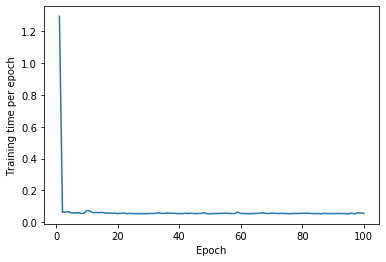

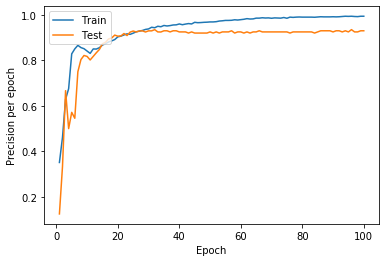

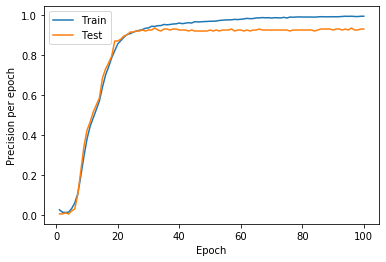

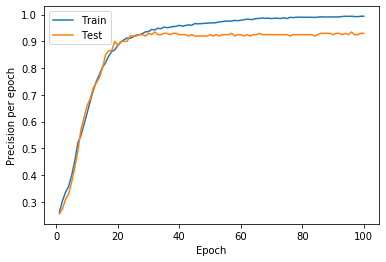

In [9]:
with mlmetrics.Classifier(model) as tracker:
    tracker.compile_model(loss='categorical_crossentropy', optimizer='adam')
    tracker.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=64)
    tracker.get_metrics(['avg_training_time', 
                         'best_precision',
                         'best_recall',
                         'best_accuracy',
                         'best_loss',
                         'total_training_time', 
                         'training_time_plot',
                         'precision_plot',
                         'recall_plot',
                         'accuracy_plot',
                         'loss_plot'], 
                        show=True, save=True)

In [10]:
#history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=64)